# Behavioral cloning project

The objective of this project is to create a model with keras thar allows autonoumous driving in a simulator.
You can find the video of the simulation as run.mp4

## Code

This code uses keras version 2.0.4 and tensorflow 1.1.0

In [1]:
import csv
import cv2
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, ELU
from keras.regularizers import l2
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.layers.noise import GaussianNoise

from random import random, choice

Using TensorFlow backend.


One of the most important hiperparameters of the model is the correction factor. This parameter corrects the angle for left and right camera images. 
The current value is the best value that I found empirically for autonomous driving in the simulator. A bigger value and the car losses the track. If the value is smaller the loss result of the model is smaller too, but the car drives to straight and doesn't take well the curves.

In [2]:
correction_factor = 0.3

This function creates the model for steering prediction. I started with a simple two layer neural network. Just to check everything is correct. Later I used a modified LeNet architecure, and the NVIDIA arquitecture. Because I wasn't getting good results with NVIDIA arquitecture I opted to modify it a bit. 

In [3]:
def create_model():
    ch, row, col = 3, 160, 320  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
                     input_shape=(row, col, ch),
                     output_shape=(row, col, ch)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding="same"))
    model.add(ELU())
    #model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
    model.add(ELU())
    #model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(128))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

I use change bright function to randomize data and as data augmentation technic.

In [4]:
def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
def change_bright(img):
    temp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Compute a random brightness value and apply to the image
    brightness = .25 + np.random.uniform()
    temp[:, :, 2] = temp[:, :, 2] * brightness
    # Convert back to RGB and return
    return cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)

Load the samples from the csv

In [6]:
def load_samples():
    with open('data/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        return list(reader)[1:]

Generator to create the training and validation data set from the csv samples. 
It randomizes the datain this way:
- 50% of the times it flips the image left to right
- 25% of the times it takes the left camera image, 25% the right, 50% the center one.

In [7]:
def generator(samples, batch_size=8):
    num_samples = len(samples)
    images = []
    angles = []
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for sample in samples:
            i = choice([0,0,1,2])
            name = './data/IMG/'+sample[i].split('/')[-1]
            image = read_image(name)
            angle = float(sample[3])
            image = change_bright(image)
            if i==1:angle += correction_factor
            if i==2:angle -= correction_factor
            if random()>0.5:
                images.append(image)
                angles.append(angle)
            else:
                images.append(np.fliplr(image))
                angles.append(-angle)
            if len(images)>=batch_size:
                X_train = np.array(images)
                y_train = np.array(angles)
                images=[]
                angles=[]
                yield shuffle(X_train, y_train)

Function to plot the loss function

In [8]:
def plot_history_object( history_object ):
    ### print the keys contained in the history object
    print(history_object.history.keys())
    for i, loss, val_loss in zip(range(1,1+len(history_object.history['loss'])),history_object.history['loss'], history_object.history['val_loss']):
        print("epoch", i)
        print("loss", loss)
        print("val_loss", val_loss)

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

Most of the images in the dataset have a steering angle of 0. To improve my model I tried to make the steering angle distribution of the dataset more even. I tried many different ways but the driving results where worse.
At the end all data is used.

In [9]:
def clean_samples(samples):
    rs = []
    for sample in samples:
        if float(sample[3])==0. and random()<=0.1:continue
        rs.append(sample)
    return rs

Train the model function. I use a training set and a validation set. There is no test set because I use the driving simulation for that.

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


def train():
    global correction_factor
    print("Starting training")
    samples = load_samples()
    #samples = clean_samples(samples)

    train_samples, validation_samples = train_test_split(samples, test_size=0.1)
    # compile and train the model using the generator function
    train_generator = generator(train_samples)
    validation_generator = generator(validation_samples)

    # 7. Define model architecture
    model = create_model()
    print("Correction", correction_factor)

    # 9. Fit model on training data
    history_object = model.fit_generator(train_generator, 
        verbose=1, 
        validation_steps=len(validation_samples), 
        epochs=1, 
        validation_data=validation_generator, 
        steps_per_epoch=len(train_samples)
    )
 
    model.save('model.h5')
    return model
    #plot_history_object(history_object)


In [11]:

#train()

## Arquitecture

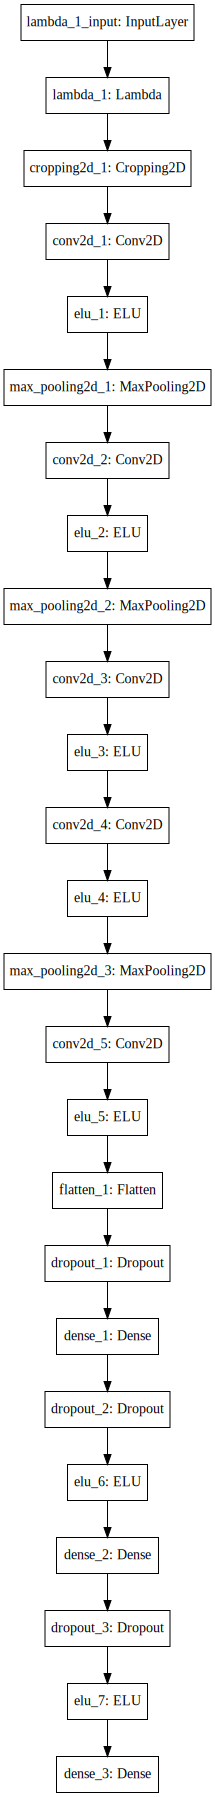

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(create_model()).create(prog='dot', format='svg'))

The arquitecture uses first normalization and a cropping layer to remove the horizon and bottom . It uses different conv nets with maxpooling and elu for non-linearity. At last there is a set of full connected layers with elu and dropout. The output is a regression layer of dimension 1.

### Visualice layers

In [13]:
test_image = np.array([read_image('data/IMG/center_2016_12_01_13_46_38_191.jpg')])

plt.imshow(test_image[0])

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import load_model



def get_layer_outputs():
    model = load_model('model.h5')
    outputs    = [layer.output for layer in model.layers]          # all layer outputs
    comp_graph = [K.function([model.input]+ [K.learning_phase()], [output]) for output in outputs]  # evaluation functions

    # Testing
    layer_outputs_list = [op([test_image, 1.]) for op in comp_graph]
    layer_outputs = []

    for layer_output in layer_outputs_list:
        #print(layer_output[0][0].shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])

    return layer_outputs

def plot_layer_outputs(layer_number):    
    layer_outputs = get_layer_outputs()

    x_max = layer_outputs[layer_number].shape[0]
    y_max = layer_outputs[layer_number].shape[1]
    n     = layer_outputs[layer_number].shape[2]

    L = []
    for i in range(n):
        L.append(np.zeros((x_max, y_max)))

    for i in range(n):
        for x in range(x_max):
            for y in range(y_max):
                L[i][x][y] = layer_outputs[layer_number][x][y][i]

    if len(L)==3: #RGB layers
        img = np.dstack(L)
        #revert normalization
        img = ((img + 1.)*127.5).astype('uint8')
        plt.figure()
        plt.imshow(img)
    else:
        for img in L:
            plt.figure()
            plt.imshow(img, interpolation='nearest')
    #img = np.array(L)
    #print("img.shape",img.shape, test_image[0].shape)
    #return
    #plt.figure()
    #plt.imshow(np.array(L[::-1]), interpolation='nearest')
        


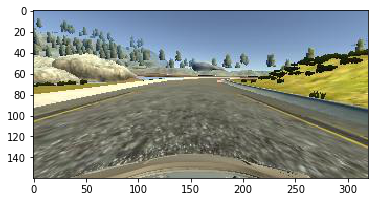

In [38]:
#show the input image
plot_layer_outputs(0)

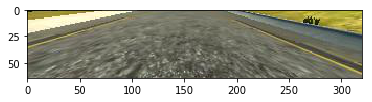

In [39]:
#show the cropped image
plot_layer_outputs(1)

/home/andres/Tools/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


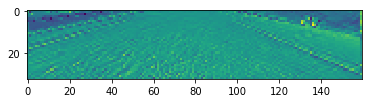

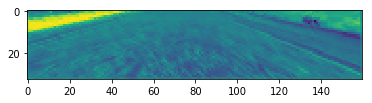

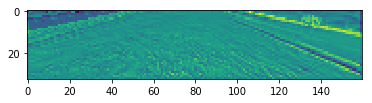

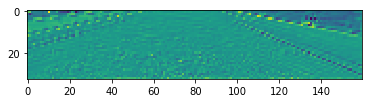

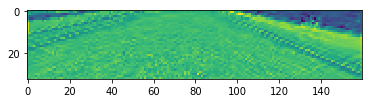

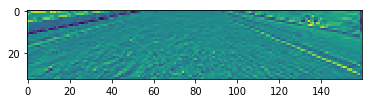

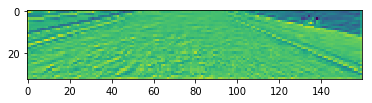

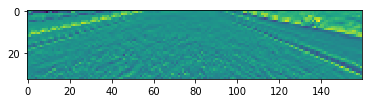

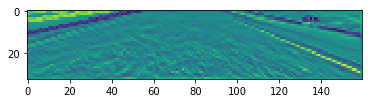

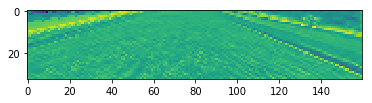

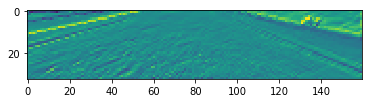

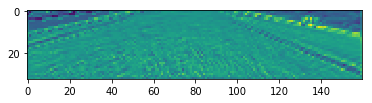

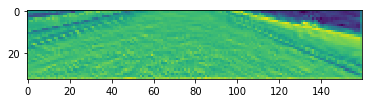

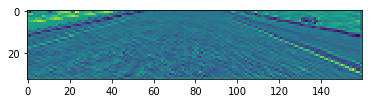

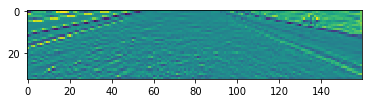

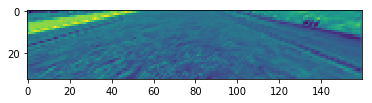

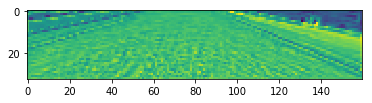

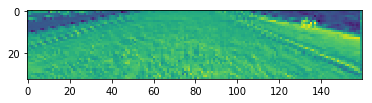

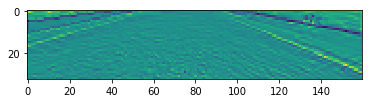

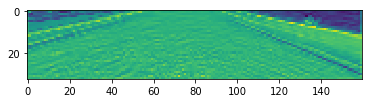

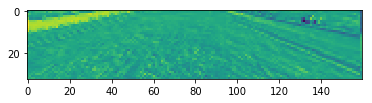

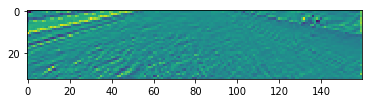

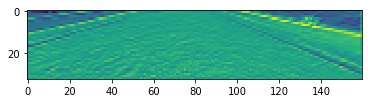

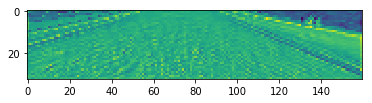

In [40]:
plot_layer_outputs(2)

## Solution Design Approach


## Final model arquitecture

I finally opted for an arquitecture between LeNet and NVIDIA. At some point I remembered that it was more important the dataset than the model. With LeNet I was underfitting and with NVIDIA overfitting. 
To really improve the model I will focus in this tasks:
- Automate the driving in the simulator. For the moment I have to do it manually and is very time consuming. I had many hiperparameters and arquitectures to test and it requires a lot effort.
- With automatic testing and validation it would be easy to build a matrix with different arquitectures and hiperparameters. Then you can compare against the simulator. 
- Minimizing the loss function is not the best way to build the model.

## Creation of the training set

I created my own training set. You can find it in my-data folder. I recorded three sets:
- 1 clockwise staying in the center.
- another one counter-clockwise staying in the center.
- another one recovering from the sides to the center.

Because my model was not working and I was not sure if the problem was in my model, in the data augmentation technics or my data quality I opted to use the udacity dataset to reduce sources of incertainity.

### Data augmentation technics

I tried many different technics to improve the dataset.

#### Clean the data
Because most of the steering angles are 0 and there are few examples with big angles. I tried to make the steering angle distribution more flat removing samples with angle 0. I got good loss result in the validation set, but a very poor result in the simulator.

#### GaussianNoise
I tried too to add a Gaussian Noise layer in my keras model. It's similar to add a dropout layer. In my model I didn't get good results and I tried other approach. With more time I can try more values to see if it improves, but my first approchimation is that it was no good

#### Flip images
I flip the images left to right and I got an improvement in the simulator.

#### Change brightness
I change the brightness of the images randomly and I got imporvement too.

#### Use left and right camera images
I use the left and right cameras with a correction factor. I got better loss function result with a correction factor around of 0.1, but better driving with 0.3. With lower values the car was not turning fast enough in the curves. With higher values the car losses control in straight road. The left and right cameras helps the car recover from the sides


## Loss function and driving simulation

To help me to tune my model I created a simple function to show me some predictions compared with the dataset.
I was trying many different models and I realized that even when I was getting better loss function results the model performed much worse in the simulator. Losss function was not a good predictor of model performance. 
I closer inspection of the predictions show me that my models behave in this way:

- The angle direction was correct. If the angle was positive my prediction was positive. If the angle was negative my prediction was negative.
- The absolute value was almost always smaller. The steering angle of my prediction was smaller than the dataset. The result was that the car was getting out of track in the curves.

My model had low angle prediction because in this way was reducing the loss. The problem is that we are not in an even problem. If the steering angle is too low the car goes out of track. If the steering angle is too big the car returns to the center. The driving will be a bit more rough but the car stays on the road.

So the characteristics that I want from the predictions are:
- Correct sign of the steering angle.
- The magnitude of the angle has to be close or bigger that the dataset angle.
- A smaller loss function doesn't imply a better model.

Using the left and right camera images with the appropiate correction factor allowed me to adjust the model to fullfil this characteristics of the prediction. It's better to make worse predictions if you improve your safety.

In [ ]:
from keras.models import load_model
import h5py
from model import generator, load_samples
import itertools
import numpy as np


def predict():
	model = load_model('model.h5')
	samples = load_samples()
	data = next(generator(samples, batch_size=32))
	X=[]
	Y=[]
	for x,y in zip(data[0], data[1]):
		print("y:",y)
		X.append(x)
		Y.append(y)
	X = np.array(X)
	Y = np.array(Y)
	predictions = model.predict(X)
	for prediction,y in zip(predictions,Y):
		prediction = prediction[0]
		print("prediction:",prediction, "y",y, "diff:",prediction-y)
	score = model.evaluate(X,Y)
	print("score", score)
    
predict()